In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import cv2
import os

# Directory where your images are located
input_directory = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia'
# Directory where you want to save the modified images
output_directory = '/kaggle/working/newinput'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Loop through the images in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith(".jpg"):  # Modify the file extension as needed
        # Load the image
        image_path = os.path.join(input_directory, filename)
        img = cv2.imread(image_path)
        
        # Zoom the image (resize)
        zoomed_img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        
        # Flip the image horizontally
        flipped_img = cv2.flip(zoomed_img, 1)
        
        # Save the modified image
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, flipped_img)

print("Images have been processed and saved to the output directory.")


Images have been processed and saved to the output directory.


In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [5]:
import os
import pandas as pd

healthy_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Normal',
    r'/kaggle/input/osteoporosis/osteoporosis/normal'
]

osteopenia_dir = [ r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia',
                  r'/kaggle/working/newinput', r'/kaggle/working/newinput']

osteoporosis_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Osteoporosis',
    r'/kaggle/input/osteoporosis/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteopenia_dir, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteopenia', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())


                                           filepaths   labels
0  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
1  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
2  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
3  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
4  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
labels
Osteoporosis    793
Healthy         780
Osteopenia      374
Name: count, dtype: int64


In [6]:
knee_osteoporosis_df.shape

(1947, 2)

In [7]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [8]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1557, 2)
(585, 2)
(390, 2)
(1362, 2)


In [9]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1557 validated image filenames belonging to 3 classes.
Found 585 validated image filenames belonging to 3 classes.
Found 390 validated image filenames belonging to 3 classes.


In [10]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteopenia', 'Osteoporosis']


In [11]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

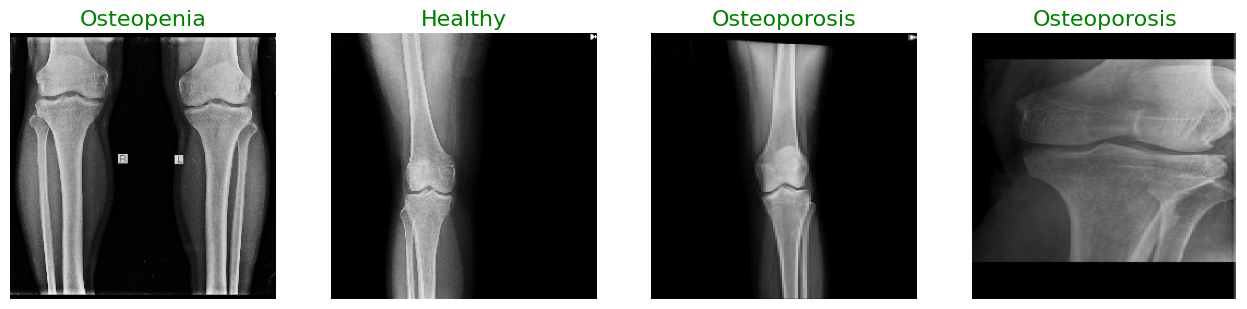

In [12]:
show_knee_images(train)

In [13]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Batc  (None, 73, 73, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 256)      0         
 )                                                               
                                                        

In [14]:
history = model.fit(train, epochs=17, validation_data=val, verbose=1)

Epoch 1/17
390/390 [==============================] - 82s 192ms/step - loss: 1.4236 - accuracy: 0.5549 - val_loss: 0.7409 - val_accuracy: 0.6974
Epoch 2/17
390/390 [==============================] - 54s 138ms/step - loss: 0.9547 - accuracy: 0.6480 - val_loss: 0.6230 - val_accuracy: 0.7641
Epoch 3/17
390/390 [==============================] - 54s 138ms/step - loss: 0.7662 - accuracy: 0.6936 - val_loss: 0.5681 - val_accuracy: 0.7846
Epoch 4/17
390/390 [==============================] - 54s 139ms/step - loss: 0.6334 - accuracy: 0.7315 - val_loss: 0.5515 - val_accuracy: 0.8103
Epoch 5/17
390/390 [==============================] - 54s 138ms/step - loss: 0.5758 - accuracy: 0.7733 - val_loss: 0.5820 - val_accuracy: 0.7949
Epoch 6/17
390/390 [==============================] - 55s 140ms/step - loss: 0.5472 - accuracy: 0.7855 - val_loss: 0.5158 - val_accuracy: 0.8051
Epoch 7/17
390/390 [==============================] - 55s 141ms/step - loss: 0.4777 - accuracy: 0.8099 - val_loss: 0.4650 - val_ac

In [15]:
model.evaluate(test, verbose=1)

147/147 [==============================] - 16s 108ms/step - loss: 0.3665 - accuracy: 0.8906


[0.3665415346622467, 0.8905982971191406]

In [16]:
model.save("Osteoporosis_Model.h5")

In [17]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

147/147 [==============================] - 15s 99ms/step


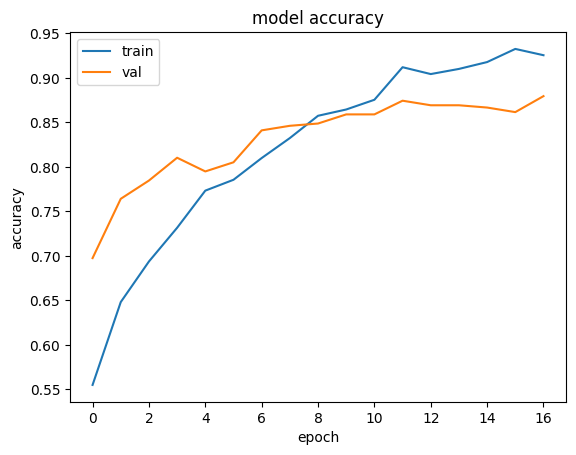

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

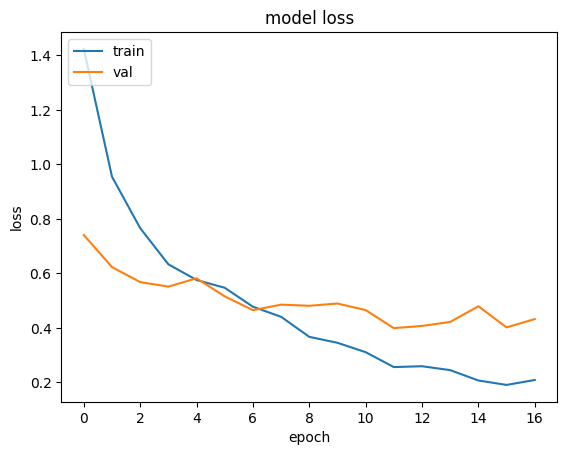

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

     Healthy       0.91      0.90      0.91       238
  Osteopenia       0.86      0.84      0.85       111
Osteoporosis       0.88      0.90      0.89       236

    accuracy                           0.89       585
   macro avg       0.89      0.88      0.88       585
weighted avg       0.89      0.89      0.89       585

Accuracy of the Model: 89.1%


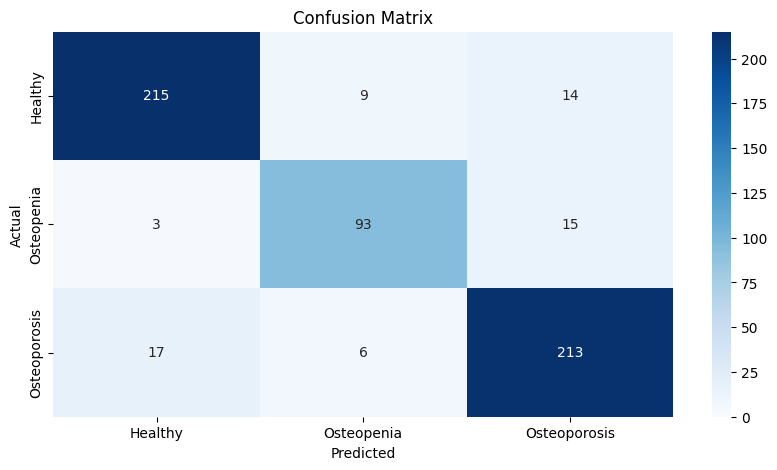

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Healthy', 'Osteopenia','Osteoporosis']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()


In [27]:

from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/kaggle/working/Osteoporosis_Model.h5')


In [28]:
import os
image_path = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia/OP108.jpg'



In [29]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)  # Read the image
    image_resized = cv2.resize(image, target_size)  # Resize the image
    image_normalized = image_resized / 255.0  # Normalize pixel values
    return np.expand_dims(image_normalized, axis=0)  # Add batch dimension


In [30]:
image_path = '/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia/OP108.jpg'

try:
    # Preprocess the image
    image_ready = preprocess_image(image_path)
    
    # Run prediction
    prediction = model.predict(image_ready)
    
    # Store the result
    results = [{'Filename': os.path.basename(image_path), 'Prediction': prediction[0]}]
    print(results)
except Exception as e:
    print(f"Error processing the image: {e}")


1/1 [==============================] - 0s 195ms/step
[{'Filename': 'OP108.jpg', 'Prediction': array([0.379603  , 0.00397294, 0.6164241 ], dtype=float32)}]


1/1 [==============================] - 0s 24ms/step


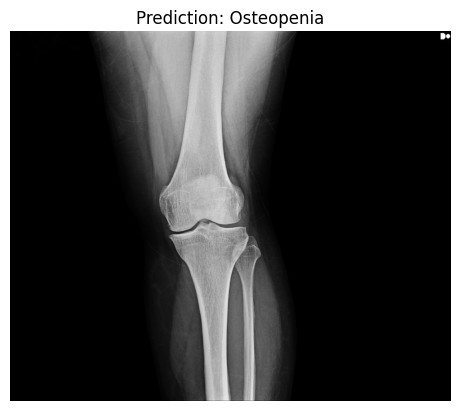

In [35]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define class labels
class_labels = ["Healthy", "Osteoporosis", "Osteopenia"]  # Ensure this matches model output

# Preprocessing function
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Attempt to read the image
image_path = "/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteopenia/OP108.jpg"  # Replace with actual path
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Unable to load the image at {image_path}")
else:
    # Convert BGR to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocess the image
    image_ready = preprocess_image(image_path)

    # Run the prediction
    prediction = model.predict(image_ready)

    # Get the predicted class index
    predicted_class_index = np.argmax(prediction[0])  # Access the first element if prediction is a batch
    predicted_class = class_labels[predicted_class_index]

    # Display the image with the predicted class
    plt.imshow(image_rgb)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()
